<a href="https://colab.research.google.com/github/kip-07/GooglecolabAI/blob/main/4_HillClimbing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, load_wine, fetch_openml
import random



In [4]:
# Generate a random N-Queens board
def generate_board(n):
    return np.random.randint(0, n, size=n)

# Calculate the number of conflicting pairs
def fitness(board):
    n = len(board)
    conflicts = 0
    for i in range(n):
        for j in range(i + 1, n):
            if board[i] == board[j] or abs(board[i] - board[j]) == abs(i - j):
                conflicts += 1
    return -conflicts  # Negative fitness (minimize conflicts)

# Generate neighboring states
def get_neighbors(board):
    n = len(board)
    neighbors = []
    for i in range(n):
        for j in range(n):
            if board[i] != j:
                neighbor = board.copy()
                neighbor[i] = j
                neighbors.append(neighbor)
    return neighbors

# Hill Climbing Algorithm
def hill_climbing(board):
    current = board
    current_fitness = fitness(current)

    while True:
        neighbors = get_neighbors(current)
        best_neighbor = max(neighbors, key=fitness)
        best_neighbor_fitness = fitness(best_neighbor)

        # Stop if no better neighbor is found
        if best_neighbor_fitness <= current_fitness:
            break

        current = best_neighbor
        current_fitness = best_neighbor_fitness

    return current, current_fitness


In [5]:
# Display the board in 'Q . . .' format
def display_board_format(board):
    n = len(board)
    print(f"\nFinal board configuration for {n}-Queens:")

    for row in range(n):
        line = ['.'] * n  # Initialize empty row
        line[board[row]] = 'Q'  # Place the queen
        print(" ".join(line))


In [6]:
# Ask the user for the board size (N)
N = int(input("Enter the value of N for N-Queens: "))

# Generate initial board
initial_board = generate_board(N)

# Apply Hill Climbing
solution, final_fitness = hill_climbing(initial_board)

# Display the final board configuration
display_board_format(solution)
print("\nFitness (negative conflicts):", final_fitness)


Enter the value of N for N-Queens: 10

Final board configuration for 10-Queens:
. . Q . . . . . . .
. . . . . Q . . . .
. . . . . . . . . Q
. Q . . . . . . . .
. . . . . . Q . . .
Q . . . . . . . . .
. . . Q . . . . . .
. . . . . . . Q . .
. . . . Q . . . . .
. . . . . . . . Q .

Fitness (negative conflicts): -1


#B) use hill climbing to select an optimal subset of features

In [27]:
# Load a dataset
def load_dataset():
    # You can change this to any UCI dataset you prefer
    # Option 1: Load Wine dataset (built-in)
    data = load_wine()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = data.target
    return X, y

In [28]:
# Evaluate a subset of features
def evaluate_feature_subset(X, y, feature_subset, classifier, cv=5):
    # Create dataset with selected features
    X_subset = X.iloc[:, feature_subset]

    # Evaluate with cross-validation
    scores = cross_val_score(classifier, X_subset, y, cv=cv, scoring='accuracy')
    return np.mean(scores)

In [29]:
# Generate a random initial feature subset
def generate_initial_subset(n_features, subset_size=None):
    if subset_size is None:
        # Random size between 1 and total features
        subset_size = random.randint(1, n_features)

    # Random selection of features
    return random.sample(range(n_features), subset_size)


In [30]:
# Generate neighboring feature subsets
def get_feature_neighbors(current_subset, n_features):
    neighbors = []

    # Add one feature (if not all features are already selected)
    if len(current_subset) < n_features:
        for i in range(n_features):
            if i not in current_subset:
                new_subset = current_subset.copy()
                new_subset.append(i)
                neighbors.append(new_subset)

    # Remove one feature (if more than one feature is selected)
    if len(current_subset) > 1:
        for i in current_subset:
            new_subset = current_subset.copy()
            new_subset.remove(i)
            neighbors.append(new_subset)

    return neighbors


In [31]:
# Hill Climbing for feature selection
def hill_climbing_feature_selection(X, y, classifier, max_iterations=100):
    n_features = X.shape[1]
    feature_names = X.columns.tolist()

    # Generate initial subset
    current_subset = generate_initial_subset(n_features)
    current_score = evaluate_feature_subset(X, y, current_subset, classifier)

    print(f"Initial feature subset: {[feature_names[i] for i in current_subset]}")
    print(f"Initial score: {current_score:.4f}")

    # Track progress
    history = [(current_subset.copy(), current_score)]

    # Hill climbing loop
    for iteration in range(max_iterations):
        # Generate all neighbors
        neighbors = get_feature_neighbors(current_subset, n_features)

        # Find the best neighbor
        best_neighbor = None
        best_score = current_score

        for neighbor in neighbors:
            score = evaluate_feature_subset(X, y, neighbor, classifier)
            if score > best_score:
                best_neighbor = neighbor
                best_score = score

        # If no improvement, stop
        if best_neighbor is None:
            print(f"No improvement found after {iteration} iterations.")
            break

        # Move to best neighbor
        current_subset = best_neighbor
        current_score = best_score
        history.append((current_subset.copy(), current_score))

        # Print progress occasionally
        if (iteration + 1) % 5 == 0:
            print(f"Iteration {iteration + 1}: Score = {current_score:.4f}, Features: {len(current_subset)}")

    # Get final selected features
    selected_features = [feature_names[i] for i in current_subset]

    return current_subset, current_score, selected_features, history


In [32]:
# Compare performance with and without feature selection
def compare_performance(X, y, selected_indices):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Selected features
    X_train_selected = X_train.iloc[:, selected_indices]
    X_test_selected = X_test.iloc[:, selected_indices]

    # Create and train classifiers
    classifiers = {
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "SVM": SVC(random_state=42)
    }

    results = {}

    for name, clf in classifiers.items():
        # All features
        clf.fit(X_train, y_train)
        all_accuracy = clf.score(X_test, y_test)

        # Selected features
        clf.fit(X_train_selected, y_train)
        selected_accuracy = clf.score(X_test_selected, y_test)

        results[name] = {
            "All Features": all_accuracy,
            "Selected Features": selected_accuracy
        }

    return results

In [33]:
# Visualize results
def visualize_results(X, selected_indices, history, comparison_results):
    feature_names = X.columns.tolist()
    selected_features = [feature_names[i] for i in selected_indices]

    # Plot feature selection progress
    plt.figure(figsize=(10, 6))
    iterations = range(len(history))
    scores = [score for _, score in history]

    plt.plot(iterations, scores, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Cross-Validation Accuracy')
    plt.title('Feature Selection Progress')
    plt.grid(True)
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    feature_status = ['Selected' if i in selected_indices else 'Not Selected' for i in range(len(feature_names))]
    feature_df = pd.DataFrame({
        'Feature': feature_names,
        'Status': feature_status
    })

    sns.barplot(x='Feature', y=[1]*len(feature_names), hue='Status',
                data=feature_df, dodge=False)
    plt.xticks(rotation=90)
    plt.ylabel('')
    plt.title('Selected Features')
    plt.tight_layout()
    plt.show()

    # Plot performance comparison
    plt.figure(figsize=(10, 6))
    models = list(comparison_results.keys())
    all_features = [comparison_results[model]["All Features"] for model in models]
    selected_features = [comparison_results[model]["Selected Features"] for model in models]

    bar_width = 0.35
    x = np.arange(len(models))

    plt.bar(x - bar_width/2, all_features, bar_width, label='All Features')
    plt.bar(x + bar_width/2, selected_features, bar_width, label='Selected Features')

    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.xticks(x, models)
    plt.legend()
    plt.ylim(0, 1.1)
    plt.show()



Loaded dataset with 178 samples and 13 features
Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']

Performing hill climbing feature selection...
Initial feature subset: ['total_phenols', 'proline', 'color_intensity']
Initial score: 0.9108
No improvement found after 2 iterations.

Best feature subset found with score: 0.9443
Selected 3 out of 13 features:
['proline', 'color_intensity', 'flavanoids']

Comparing model performance...

Decision Tree:
  Accuracy with all features: 0.9630
  Accuracy with selected features: 0.9444
  Improvement: -0.0185

SVM:
  Accuracy with all features: 0.7593
  Accuracy with selected features: 0.7407
  Improvement: -0.0185


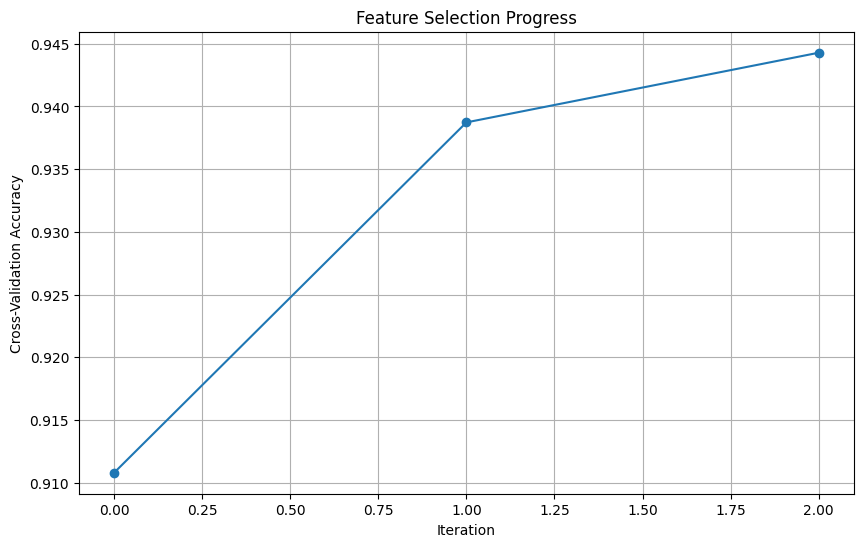

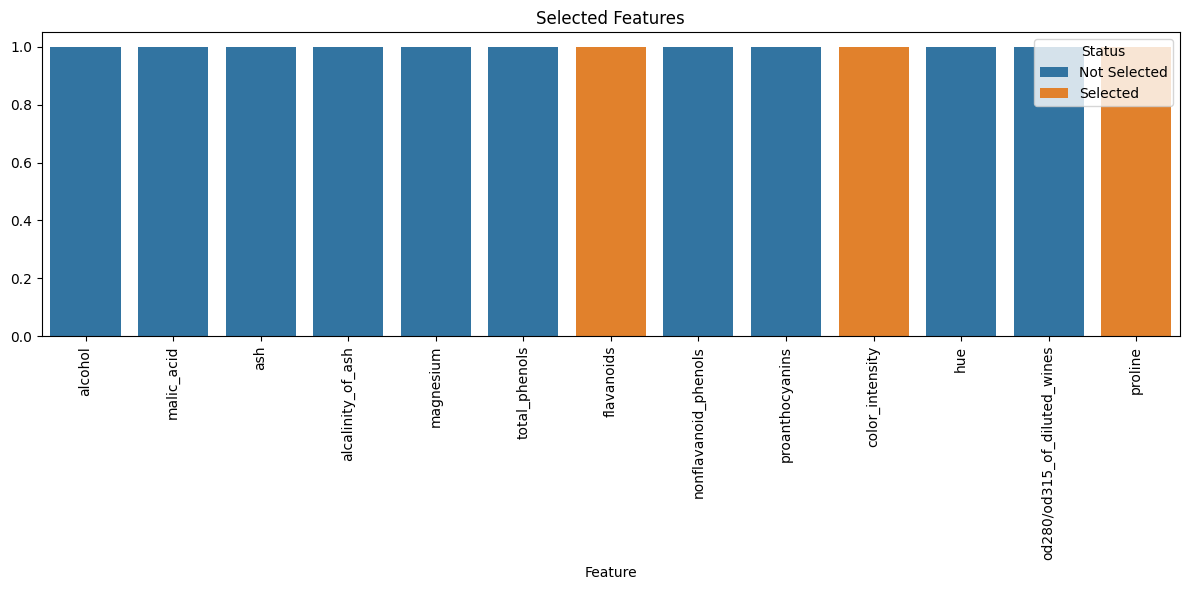

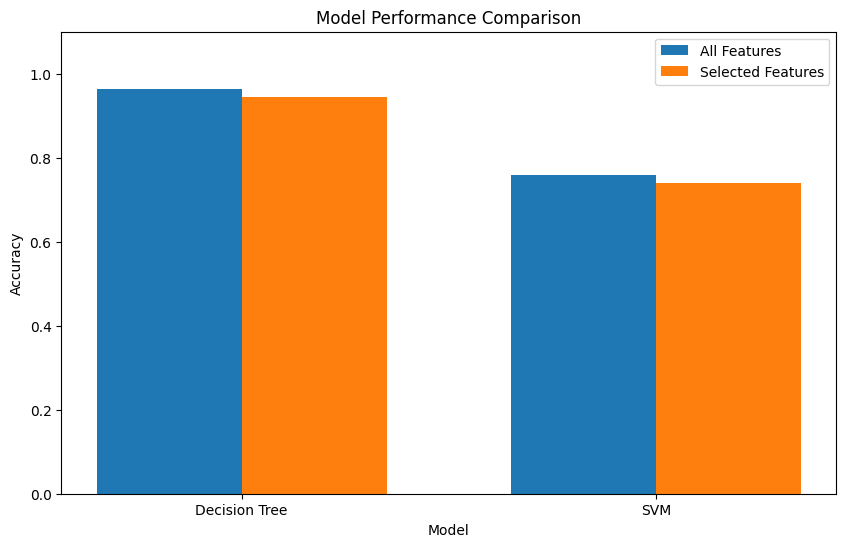

In [34]:
# Main function to run the feature selection
def main():
    # Load data
    X, y = load_dataset()
    print(f"Loaded dataset with {X.shape[0]} samples and {X.shape[1]} features")
    print(f"Feature names: {X.columns.tolist()}")

    # Create classifier for feature selection
    classifier = DecisionTreeClassifier(random_state=42)

    # Perform hill climbing feature selection
    print("\nPerforming hill climbing feature selection...")
    selected_indices, best_score, selected_features, history = hill_climbing_feature_selection(
        X, y, classifier, max_iterations=50)

    print(f"\nBest feature subset found with score: {best_score:.4f}")
    print(f"Selected {len(selected_features)} out of {X.shape[1]} features:")
    print(selected_features)

    # Compare performance
    print("\nComparing model performance...")
    comparison_results = compare_performance(X, y, selected_indices)

    # Print comparison results
    for model, results in comparison_results.items():
        print(f"\n{model}:")
        print(f"  Accuracy with all features: {results['All Features']:.4f}")
        print(f"  Accuracy with selected features: {results['Selected Features']:.4f}")
        print(f"  Improvement: {results['Selected Features'] - results['All Features']:.4f}")

    # Visualize results
    visualize_results(X, selected_indices, history, comparison_results)

if __name__ == "__main__":
    main()